# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### Stating Problem
The goal of this project is to find some factors and build a machine learning(ML) that predicts what makes a customer complete an offer. I am mostly interested in the demographics as I believe that they are bigger factors than the offer types. <br> <br>
With the data provided, I will answer the above questions with the help of charts and various ML models which will be fed the data from a merged dataset which consists of the following: portfolio, profile, transactional. 

### Metrics
The metric that I have chosen to use is the F!-Score because the dataset is highly imbalanced. Therefore, for this situation, I'll be evaluating the models' precision and recall provides better insight into its performance. In turn, this led me to choosing the F1-Score which can be interpertaed as a harmonic mean of the precision and recall, where an [F1 score reaches its best value at 1 and worst score at 0](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [1]:
# this project was done in Google Colab because my kernel keeps 
# dying while trying various model. Despite trying many different
# solution, the problem still persisted.
from google.colab import files
 
 
uploaded = files.upload()

Saving transcript.json to transcript.json
Saving profile.json to profile.json
Saving portfolio.json to portfolio.json


In [2]:
import os
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

In [3]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Data Assessement
### Assessing Portfolio Data

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


### Assessing Transcript Data

In [7]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [8]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [9]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [10]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [11]:
transcript[(transcript.event == 'offer completed')]

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


### Assessing Profile Data

In [12]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [13]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile.duplicated().sum()

0

In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


## Data Preprocessing Part I - Preliminary Data Wrangling
### Cleaning Transcript Data
**`1.` Rename 'person' column name to 'customer_id'.**

In [16]:
# renaming column to avoid any confusion later on
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

**`2.` Seperate 'value' column into 3 new columns: amount, order_id, and rewards.**

In [17]:
key_list = []
for i in range(len(transcript.value)):
    if (transcript.value[i].keys()) not in key_list:
        key_list.append(transcript.value[i].keys())
key_list

[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

In [18]:
# function for creating new columns
def create_rewards_col(df):
    rewards_list = []
    for i in range(len(df.value)):
            rewards_list.append(df.value[i].get('rewards'))
    return rewards_list

def create_amount_col(df):
    amount_list = []
    for i in range(len(df.value)):
            amount_list.append(df.value[i].get('amount'))
    return amount_list

def create_order_id_col(df):
    order_id_list = []
    keys_to_lookup = ['offer id', 'offer_id']

    for i in range(len(df.value)):
        if keys_to_lookup[0] in df.value[i]:
            order_id_list.append(df.value[i].get(keys_to_lookup[0]))
        elif keys_to_lookup[1] in df.value[i]:
            order_id_list.append(df.value[i].get(keys_to_lookup[1]))
        else:
            order_id_list.append(np.nan)
    return order_id_list

In [19]:
transcript['rewards'] = create_rewards_col(transcript)
transcript['amount'] = create_amount_col(transcript)
transcript['offer_id'] = create_order_id_col(transcript)

# check
transcript.head()

,customer_id,event,value,time,rewards,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,None,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,None,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,None,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,None,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


**`3.` Drop 'value' and 'rewards' column.**

In [20]:
#before, we clean take a look at the rewards column
# it's full of nulls! So, we should remove it
transcript.rewards.isnull().sum()

306534

In [21]:
transcript.drop(columns = ['value', 'rewards'], inplace = True)

#check
transcript.head()

,customer_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


**`4.` Convert amount column to float.**

In [22]:
transcript.amount.astype('float')
transcript.amount.dtype

dtype('float64')

**`5.` Drop all rows from transcript where 'customer_id' not in profile.id .**

In [23]:
transcript = transcript[transcript.customer_id.isin(profile.id)] # no rows were dropped

**`5.` Convert 'time' column from hours to days.**

In [24]:
transcript.time /= 24
transcript.tail()

,customer_id,event,time,amount,offer_id
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,3.53,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,29.75,4.05,NaN


**`6.` Split event column into 4 columns: 'offer_received', 'offer_viewed', 'offer_completed' and 'transaction'.**

In [25]:
transcript['offer_received'] = transcript['event'].apply(lambda x: 1 if x == 'offer received' else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['transaction'] = transcript['event'].apply(lambda x: 1 if x == 'transaction' else 0)

# drop event column
transcript.drop(columns = ['event'], inplace = True)
# check
transcript.head(1)

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0


**`7.` Drop duplicates rows if any.**

In [26]:
transcript.duplicated().sum() # there are a total of 2962 duplicate rows
transcript.drop_duplicates(inplace = True)

#check
transcript.duplicated().sum()

0

### Cleaning Profile Data
**`1.` Replace 118 in age column with null value.**

In [27]:
profile.age = profile.age.replace(118, np.nan)

#Check 
profile.age.head()

0     NaN
1    55.0
2     NaN
3    75.0
4     NaN
Name: age, dtype: float64

**`2.` Convert 'became_member_on' column fron integer to datetime datatype.**

In [28]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [29]:
profile['became_member_on'].dtype

dtype('<M8[ns]')

**`3.` Rename 'id' column name to 'customer_id'.**

In [30]:
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

#Check
profile.head(1)

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN


### Cleaning Portfolio Data
**`1.` Rename 'id' column to order_id**

In [31]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

# check
portfolio.head(1)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


**`2.` Split 'channels' column into 4 columns: 'web', 'mobile', 'email' and 'social'.**

In [32]:
portfolio['web'] = portfolio.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio['mobile'] = portfolio.channels.apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['email'] = portfolio.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio['social'] = portfolio.channels.apply(lambda x: 1 if 'social' in x else 0)

# drop channels column
portfolio.drop(columns = ['channels'], inplace = True)

#check 
portfolio.head(1)

,reward,difficulty,duration,offer_type,offer_id,web,mobile,email,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1


**`3.` Merge transcript dataset with portfolio dataset to make new dataset called 'transcript_portfolio'.**

In [33]:
transcript_portfolio = transcript.merge(portfolio, how = 'left', on = 'offer_id')

In [34]:
transcript_portfolio

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,duration,offer_type,web,mobile,email,social
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,5.0,20.0,10.0,discount,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0.00,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306133,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306134,a00058cf10334a308c68e7631c529907,29.75,3.61,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306135,76ddbd6576844afe811f1a3c0fbb5bec,29.75,3.53,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Visual Explorations
As a reminder, there are two datasets as demonstrated down below.

In [35]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [36]:
transcript_portfolio.head()

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,duration,offer_type,web,mobile,email,social
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,5.0,20.0,10.0,discount,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


### Profile Gender Count

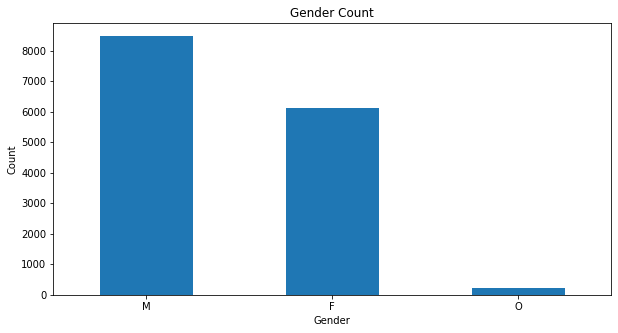

In [37]:
fig = plt.figure(figsize = (10,5))
ax = profile.gender.value_counts().plot(kind = 'bar')

plt.xticks(rotation = 360)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Count');

**Over 8,000 of the Starbucks profile collected identify as male while about 6,000 identify as feamle. Very few customer identify as 'Others'.**

### Profile Income Distribution

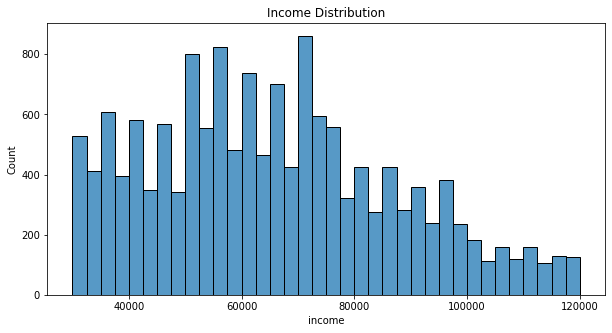

In [38]:
fig = plt.figure(figsize = (10,5))
sb.histplot(data = profile, x = 'income')
plt.title('Income Distribution');

**The income is skewed to the right a little bit. It seems like the highest count is around the $70,000 income mark and a majority make less than that. I wonder what the distribution would look like if I seperate them by gender.**

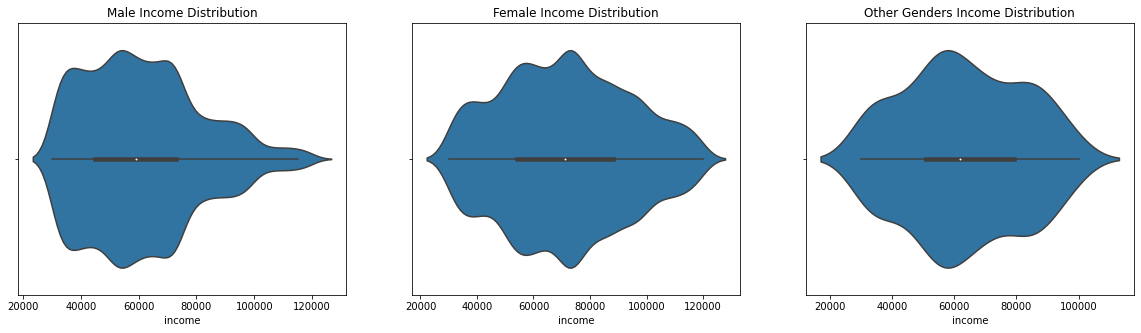

In [39]:
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = sb.violinplot(profile.query('gender == "M"')['income'], ax = ax[0])
ax1.title.set_text('Male Income Distribution');
ax2 = sb.violinplot(profile.query('gender == "F"')['income'], ax = ax[1])
ax2.title.set_text('Female Income Distribution');
ax3 = sb.violinplot(profile.query('gender == "O"')['income'], ax = ax[2])
ax3.title.set_text('Other Genders Income Distribution');

**This is pretty interesting. The income seems evely distributed for every gender except fot the males. We can see that the majority of male members have income less than $80,000.**



### Profile Age Distribution

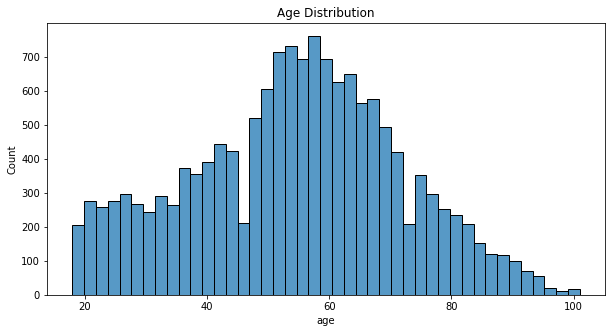

In [40]:
fig = plt.figure(figsize = (10,5))
sb.histplot(data = profile, x = 'age')
plt.title('Age Distribution');

**The age seems to be pretty normally distributed. Near the end it begins to taper off which makes sense since it's very rare to come across some one who is older than 90. Similair to what we did for the income, let's see what the distribution for age is like for age.**

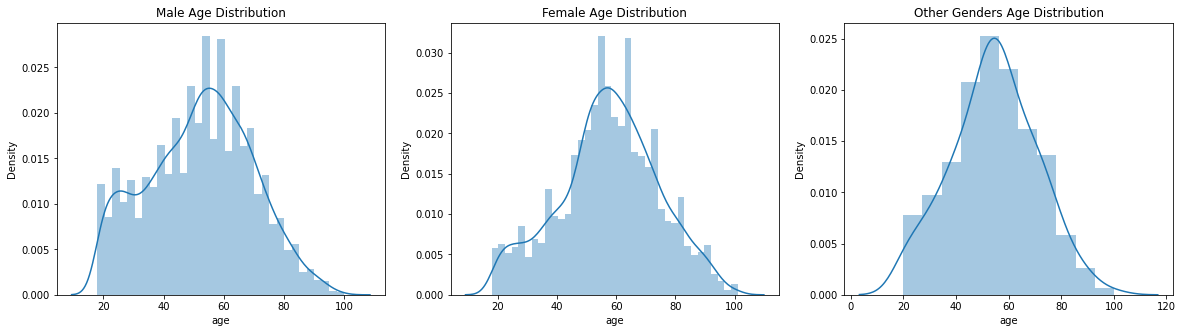

In [41]:
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = sb.distplot(profile.query('gender == "M"')['age'], ax = ax[0])
ax1.title.set_text('Male Age Distribution');
ax2 = sb.distplot(profile.query('gender == "F"')['age'], ax = ax[1])
ax2.title.set_text('Female Age Distribution');
ax3 = sb.distplot(profile.query('gender == "O"')['age'], ax = ax[2])
ax3.title.set_text('Other Genders Age Distribution');



### Profile Membership Started By Year

In [42]:
profile['became_member_on'].groupby(profile['became_member_on'].dt.year).count()

became_member_on
2013     286
2014     691
2015    1830
2016    3526
2017    6469
2018    4198
Name: became_member_on, dtype: int64

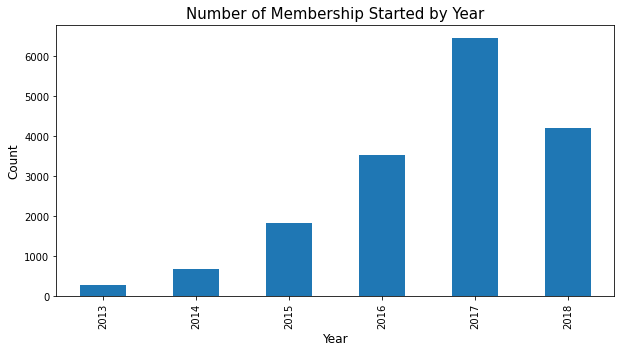

In [43]:
fig = plt.figure(figsize = (10,5))

ax = profile['became_member_on'].groupby(profile['became_member_on'].dt.year).count().plot(kind = 'bar')
plt.title('Number of Membership Started by Year', fontsize = 15)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Count', fontsize = 12);

**Wow! It seems like Starbucks has acquire a ton of new members in 2017 with over 6000. However, it not that many joined in 2018 which a little strange.**
### Time Distribution 

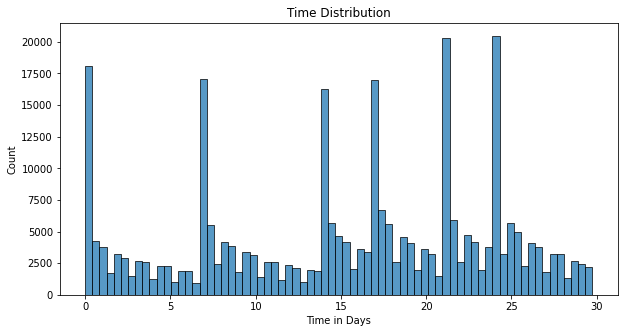

In [44]:
fig = plt.figure(figsize = (10,5))
sb.histplot(data = transcript_portfolio, x = 'time')
plt.title('Time Distribution')
plt.xlabel("Time in Days");

**As we can see above, the graph depicts a multimodal distribution with several big spikes.**
### Types of Offer Distribution By Event

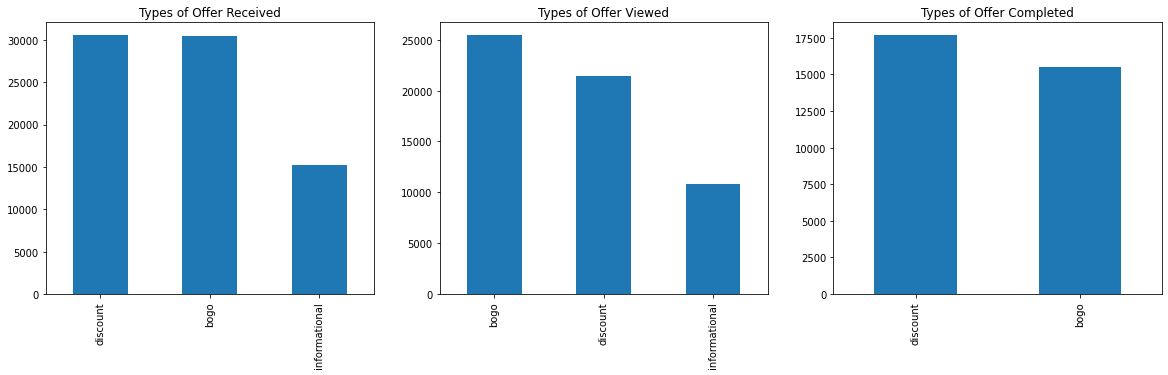

In [45]:
fig, ax = plt.subplots(1, 3, figsize = [20, 5])
ax1 = transcript_portfolio[transcript_portfolio.offer_received == 1].offer_type.value_counts().plot(kind = 'bar', 
                                                                                                   ax = ax[0])
ax1.title.set_text('Types of Offer Received');

ax2 = transcript_portfolio[transcript_portfolio.offer_viewed == 1].offer_type.value_counts().plot(kind = 'bar',
                                                                                                 ax = ax[1])
ax2.title.set_text('Types of Offer Viewed');

ax3 = transcript_portfolio[transcript_portfolio.offer_completed == 1].offer_type.value_counts().plot(kind = 'bar',
                                                                                                 ax = ax[2])
ax3.title.set_text('Types of Offer Completed');

**Beginning with the 1st bar plot on the left, we can see that a members have received the same amount of discount and bogo("buy one, get one"). When we look at the second graph, we can see that more people have viewed the bogo offer which might means that it's more attractive. However, most people have completed the discount offer. I wonder if it has something to do with the difficulty. <br><br> Now that I've had a better look at the data, there are several more preprocessing acts I would like to do.**

## Data Preprocessing Part II - Getting Data Ready For Modeling
**`1.` Merge transcript_portfolio and profile to create master df.**

In [46]:
df_master = transcript_portfolio.merge(profile, how = 'inner', on = 'customer_id')
df_master.head()

,customer_id,time,amount,offer_id,offer_received,offer_viewed,offer_completed,transaction,reward,difficulty,duration,offer_type,web,mobile,email,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,19.89,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75.0,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,6.00,17.78,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,2017-05-09,100000.0


**`2.` Encode gender column.**

In [47]:
df_master['gender'] = df_master.gender.apply(lambda x: 1 if x == 'F' else 2 if (x=='M')\
                                                             else 3 if x == 'O' else np.nan)

In [48]:
# check
df_master.head()
df_master['gender'].unique()

array([ 1., nan,  2.,  3.])

**`3.` Create subset for modeling.**

In [49]:
df_master = df_master[['time', 'amount', 'offer_completed', 'reward', 
                       'difficulty', 'age', 'income', 'gender']]


**`4.` Drop all income with null values.**

In [50]:
df_master.dropna(subset=['income'], inplace = True)

**`5.` Fill all null values with 0.**

In [51]:
# null values should be an indication of no amount being spent or earned
# for example, a null amount indicates no money being spent which is basically 0
df_master.fillna(0, inplace = True)

In [52]:
# check
df_master.isnull().sum()

time               0
amount             0
offer_completed    0
reward             0
difficulty         0
age                0
income             0
gender             0
dtype: int64

## Splitting Data

In [53]:
X = df_master[['time', 'amount','reward', 'difficulty', 'age', 'income', 'gender']]
y =  df_master['offer_completed']

In [54]:
X.head()

,time,amount,reward,difficulty,age,income,gender
0,0.00,0.00,5.0,5.0,75.0,100000.0,1.0
1,0.25,0.00,5.0,5.0,75.0,100000.0,1.0
2,5.50,19.89,0.0,0.0,75.0,100000.0,1.0
3,5.50,0.00,5.0,5.0,75.0,100000.0,1.0
4,6.00,17.78,0.0,0.0,75.0,100000.0,1.0


In [55]:
# Normalize help: https://datagy.io/pandas-normalize-column/
scaler = MinMaxScaler()
normalize_col = list(X.columns)

X[normalize_col] = scaler.fit_transform(X[normalize_col])

In [56]:
X.head()

,time,amount,reward,difficulty,age,income,gender
0,0.000000,0.000000,0.5,0.25,0.686747,0.777778,0.0
1,0.008403,0.000000,0.5,0.25,0.686747,0.777778,0.0
2,0.184874,0.018724,0.0,0.00,0.686747,0.777778,0.0
3,0.184874,0.000000,0.5,0.25,0.686747,0.777778,0.0
4,0.201681,0.016738,0.0,0.00,0.686747,0.777778,0.0


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204291, 7), (68097, 7), (204291,), (68097,))

## Modeling Data

In [59]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
# checking for accuracy imbalance
(df_master.offer_completed.value_counts()/df_master.offer_completed.count())*100

0    88.226354
1    11.773646
Name: offer_completed, dtype: float64

**Wow! Here we can tell that the offers_completed in the dataset is wildly imbalanced. Since offer completed is very underrepresented, we will be using the F1-score as our metric. You can read this [KDNuggets article](https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html) to find out how I have come to this conclusion.**

### `1.` Logistic Regression

In [61]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

In [62]:
accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lr_pred))
print('Classification Report: \n', classification_report(y_test, lr_pred))

Accuracy: 87.95%
F1-Score: 0.09449166574677118
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     60243
           1       0.36      0.05      0.09      7854

    accuracy                           0.88     68097
   macro avg       0.62      0.52      0.51     68097
weighted avg       0.83      0.88      0.84     68097



### `2.` Ada Boost Classifier

In [63]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

ada_pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, ada_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, ada_pred))
print('Classification Report: \n', classification_report(y_test, ada_pred))

Accuracy: 89.35%
F1-Score: 0.3144665973731456
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     60243
           1       0.61      0.21      0.31      7854

    accuracy                           0.89     68097
   macro avg       0.76      0.60      0.63     68097
weighted avg       0.87      0.89      0.87     68097



### `3.` Random Forest Classifier

In [64]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, rf_pred))
print('Classification Report: \n', classification_report(y_test, rf_pred))

Accuracy: 86.98%
F1-Score: 0.33848220282068503
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     60243
           1       0.41      0.29      0.34      7854

    accuracy                           0.87     68097
   macro avg       0.66      0.62      0.63     68097
weighted avg       0.85      0.87      0.86     68097



### `4.` K Neighbors Classifier

In [65]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

knc_pred = knc.predict(X_test)

accuracy = accuracy_score(y_test, knc_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, knc_pred))
print('Classification Report: \n', classification_report(y_test, knc_pred))

Accuracy: 88.40%
F1-Score: 0.33557611438183343
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     60243
           1       0.49      0.25      0.34      7854

    accuracy                           0.88     68097
   macro avg       0.70      0.61      0.64     68097
weighted avg       0.86      0.88      0.87     68097



### `5.` Decision Tree Classifier

In [66]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, dt_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, dt_pred))
print('Classification Report: \n', classification_report(y_test, dt_pred))

Accuracy: 87.65%
F1-Score: 0.45917448887745915
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     60243
           1       0.46      0.45      0.46      7854

    accuracy                           0.88     68097
   macro avg       0.70      0.69      0.69     68097
weighted avg       0.88      0.88      0.88     68097



### `6.` Random Forest Classifier

In [67]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, rfc_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, rfc_pred))
print('Classification Report: \n', classification_report(y_test, rfc_pred))

Accuracy: 87.03%
F1-Score: 0.3452469227346878
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     60243
           1       0.41      0.30      0.35      7854

    accuracy                           0.87     68097
   macro avg       0.66      0.62      0.64     68097
weighted avg       0.85      0.87      0.86     68097



### `7.` Gradient Boosting Classifier

In [68]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

gbc_pred = gbc.predict(X_test)

accuracy = accuracy_score(y_test, gbc_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, gbc_pred))
print('Classification Report: \n', classification_report(y_test, gbc_pred))

Accuracy: 90.57%
F1-Score: 0.5413361914969632
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     60243
           1       0.62      0.48      0.54      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.72      0.74     68097
weighted avg       0.90      0.91      0.90     68097



### `8.` XGB Classifier

In [69]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, xgb_pred))
print('Classification Report: \n', classification_report(y_test, xgb_pred))

Accuracy: 90.37%
F1-Score: 0.4703317994671833
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     60243
           1       0.64      0.37      0.47      7854

    accuracy                           0.90     68097
   macro avg       0.78      0.67      0.71     68097
weighted avg       0.89      0.90      0.89     68097



### `9.` LGBM Classifier

In [74]:
import lightgbm as lgbm 

lgb = lgbm.LGBMClassifier()
lgb.fit(X_train, y_train)

lgb_pred = lgb.predict(X_test)

accuracy = accuracy_score(y_test, lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lgb_pred))
print('Classification Report: \n', classification_report(y_test, lgb_pred))


Accuracy: 90.69%
F1-Score: 0.5764886720577425
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.55      0.58      7854

    accuracy                           0.91     68097
   macro avg       0.77      0.75      0.76     68097
weighted avg       0.90      0.91      0.90     68097



**Based on the result above, the LGBM Classifier not only scored the highest f1-score with 0.58 which is the metric we have chosen to analyze the performance on test data, but also the  highest accuracy with 90.69%! I will now use this model for tuning based off of this finding.**

## Hyperparameter Tuning
I used this Kaggle link for [hyperparameter tuning help](https://colab.research.google.com/drive/1Ky4LZnEj1jK30I9pjcmdaX3aivA6WkA5?authuser=3#scrollTo=01dBdZihvH67&line=4&uniqifier=1) and [this link](https://setscholars.net/wp-content/uploads/2019/02/find-optimal-parameters-using-GridSearchCV-in-Python.html).

In [78]:
parameters = {'num_leaves': [100,500], 
             'application' : ['binary'],
             'boosting' : ['gbdt','dart'],
             'learning_rate' : [0.001,0.01,0.1],
              'n_estimators' : [100,150, 250],
              'max_depth'    : [4,6] 
            }
grid = GridSearchCV(estimator=lgb, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
    grid.best_estimator_)
print("\n The best score across ALL searched params:\n",
    grid.best_score_)
print("\n The best parameters across ALL searched params:\n",
    grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMClassifier(application='binary', boosting='gbdt', max_depth=4,
               n_estimators=150, num_leaves=100)

 The best score across ALL searched params:
 0.9088701897583311

 The best parameters across ALL searched params:
 {'application': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'num_leaves': 100}



In [79]:
lgb = lgbm.LGBMClassifier(application='binary', boosting='gbdt', max_depth=4,
               n_estimators=150, num_leaves=100)
lgb.fit(X_train, y_train)

lgb_pred = lgb.predict(X_test)

accuracy = accuracy_score(y_test, lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lgb_pred))
print('Classification Report: \n', classification_report(y_test, lgb_pred))


Accuracy: 90.76%
F1-Score: 0.5783617106850784
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     60243
           1       0.61      0.55      0.58      7854

    accuracy                           0.91     68097
   macro avg       0.78      0.75      0.76     68097
weighted avg       0.90      0.91      0.91     68097



**After hypertuning the model, we still don't see any significant improvement. We only managed to improve the F1-Score by 0.002. However, it is still the most accurate one that we have in terms of F1-score and accuracy, so we will take this one as our final model. There could be a better model out there.**

In [81]:
#Critical features impacting completion of offer
# Please refer to the Kaggle link above 

#get all feature names
labels = X_train.columns.tolist()

feature_imp = pd.DataFrame(lgb.feature_importances_,index=labels,columns=['feat_imp']).reset_index()

feature_imp.rename(columns={'index': 'Feature'}, inplace=True)

#calculate how feature ranks vs rest of the features
feature_imp['Importance_Percent'] = np.round((feature_imp['feat_imp']/feature_imp['feat_imp'].sum())*100,2)

#sort the feature list according to importance
feature_imp = feature_imp.sort_values(by=['Importance_Percent'], ascending=False).reset_index(drop=True)

#remove the feat_imp field used in calculation 
feature_imp.drop(columns=['feat_imp'],inplace=True)

#display the top 10 features
feature_imp.head(10)

,Feature,Importance_Percent
0,time,50.23
1,income,13.16
2,age,10.12
3,reward,9.40
4,gender,6.92
5,difficulty,5.94
6,amount,4.23


## Conclusion
**In conclusion, the top 3 most important features that impacts a customer completing an offer is the time taken to act on it, the customer's income and age. <br> <br>
While the LGBM Classifier is the most accurate model that we have, the model can be improved further. One potential solution might be adding more relevant features.**